In [1]:
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
with open("./output.json") as f:
    anno = json.load(f)

In [3]:
tag_dict={}
remove_tags = ['solo','looking_at_viewer','smile','hand_on_hip','standing','full_body','hand_in_pocket','arm_at_side']
for name,data in anno.items():
    tags = list(data['general'].keys())
    tags = [tag for tag in tags if 'background' not in tag]
    tags = [tag for tag in tags if tag not in remove_tags]
    tag_dict[name] = tags

In [4]:
differ_dict = {}
def differ_tag(tag_a,tag_b):
    removed = set(tag_a) - set(tag_b)
    added = set(tag_b) - set(tag_a)
    return added,removed
previous_tags = []
for name,tags  in tag_dict.items():
    added,removed = differ_tag(previous_tags,tags)
    differ_dict[name]={'added':added,'removed':removed}
    previous_tags = tags

In [5]:
from collections import Counter
def get_counter(tag_dict):
    tag_counter = Counter()
    for name,data in tag_dict.items():
        tag_counter.update(data)
    return tag_counter
def get_tags_by_count(data,count=1):
    return [i for i in data if data[i] == count]

def filter_tags(tag_dict,min_count=2):
    tag_counter = get_counter(tag_dict)
    remove=[]
    for i in range(min_count-1):
        remove += get_tags_by_count(tag_counter,i+1)
    for name,tags in tag_dict.items():
        tags = [tag for tag in tags if tag not in remove]
        tag_dict[name] = tags
    return tag_dict

In [6]:
filter_tag_dict = filter_tags(tag_dict,min_count=10)
tag_count_df = pd.DataFrame.from_dict(get_counter(filter_tag_dict), orient='index').reset_index().rename(columns={'index':'tag', 0:'count'})
tag_count_df.sort_values(by=['count'], inplace=True,ascending=False)
len(tag_count_df)

105

In [7]:
fig = px.bar(tag_count_df, x=tag_count_df.tag,y='count')
fig.show()

In [8]:
fig.write_image("fig1.png")

In [9]:
all_tags = tag_count_df.tag.unique()
template = {"idx":False}
for tag in all_tags:
    template[tag] = False
tag_list=[]
for name,data in filter_tag_dict.items():
    tmp = template.copy()
    tmp['idx'] = name
    for tag in data:
        tmp[tag] = True
    tag_list.append(tmp)

In [10]:
tag_df = pd.DataFrame(tag_list)

In [11]:
tag_df['frame'] = tag_df.idx.apply(lambda x: x.split("_")[1])

In [12]:
tag_df['timestamp'] = tag_df.frame.apply(lambda x: int(x)*0.5)

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

In [14]:
tag_df.set_index('frame',inplace=True)

In [15]:
import plotly.graph_objects as go
plot_df = tag_df[tag_df.columns.difference(['idx', 'timestamp'])]

fig = px.imshow(plot_df.to_numpy().astype(int).T,x=plot_df.index,y=plot_df.columns, aspect="auto")
fig.update_layout(yaxis_nticks=len(all_tags),height=1500)
fig.show()

In [16]:
fig.write_image("fig2.png")

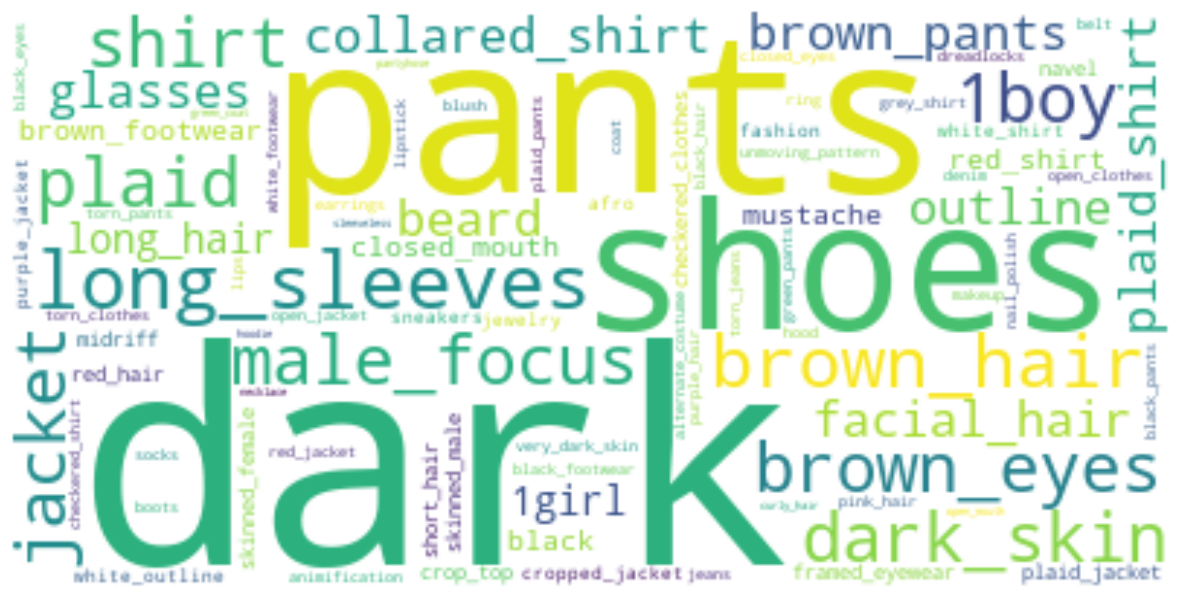

In [17]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(','.join(tag_count_df.tag))
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()